In [1]:
from tensorflow.keras import datasets, layers, models
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def preprocess(imgs):
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [4]:
import tensorflow.keras.backend as K

encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation='relu', padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)


In [5]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
decoder_Input = layers.Input(shape=(2,), name='decoder_input')
x= layers.Dense(np.prod(shape_before_flattening))(decoder_Input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    64, (3,3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    32, (3,3), strides=2, activation='relu', padding='same'
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name='decoder_output'
)(x)

decoder = models.Model(decoder_Input, decoder_output)

In [7]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

autoencoder.compile(optimizer="adam", loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train,
                y=x_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.3563 - val_loss: 0.2648
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2608 - val_loss: 0.2575
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2554 - val_loss: 0.2546
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2527 - val_loss: 0.2533
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2512 - val_loss: 0.2519


In [9]:
pred = autoencoder.predict(x_test[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


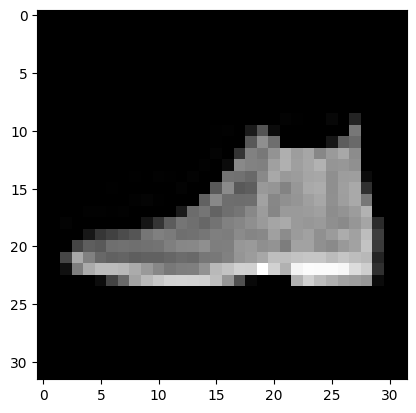

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0], cmap='gray')
plt.show()

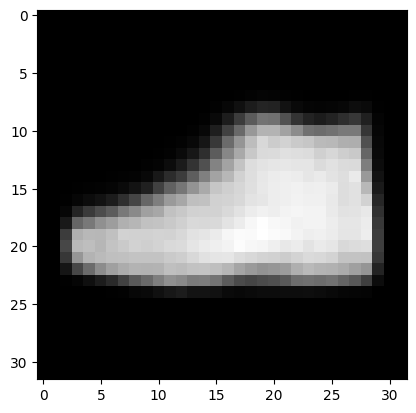

In [11]:
import matplotlib.pyplot as plt
plt.imshow(pred[0], cmap='gray')
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


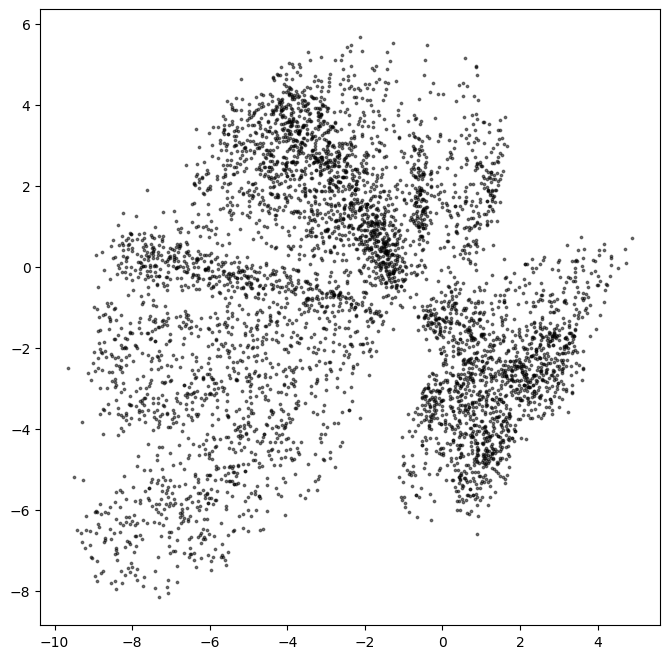

In [12]:
example_images = x_test[:5000]
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

In [13]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


<Figure size 640x480 with 0 Axes>

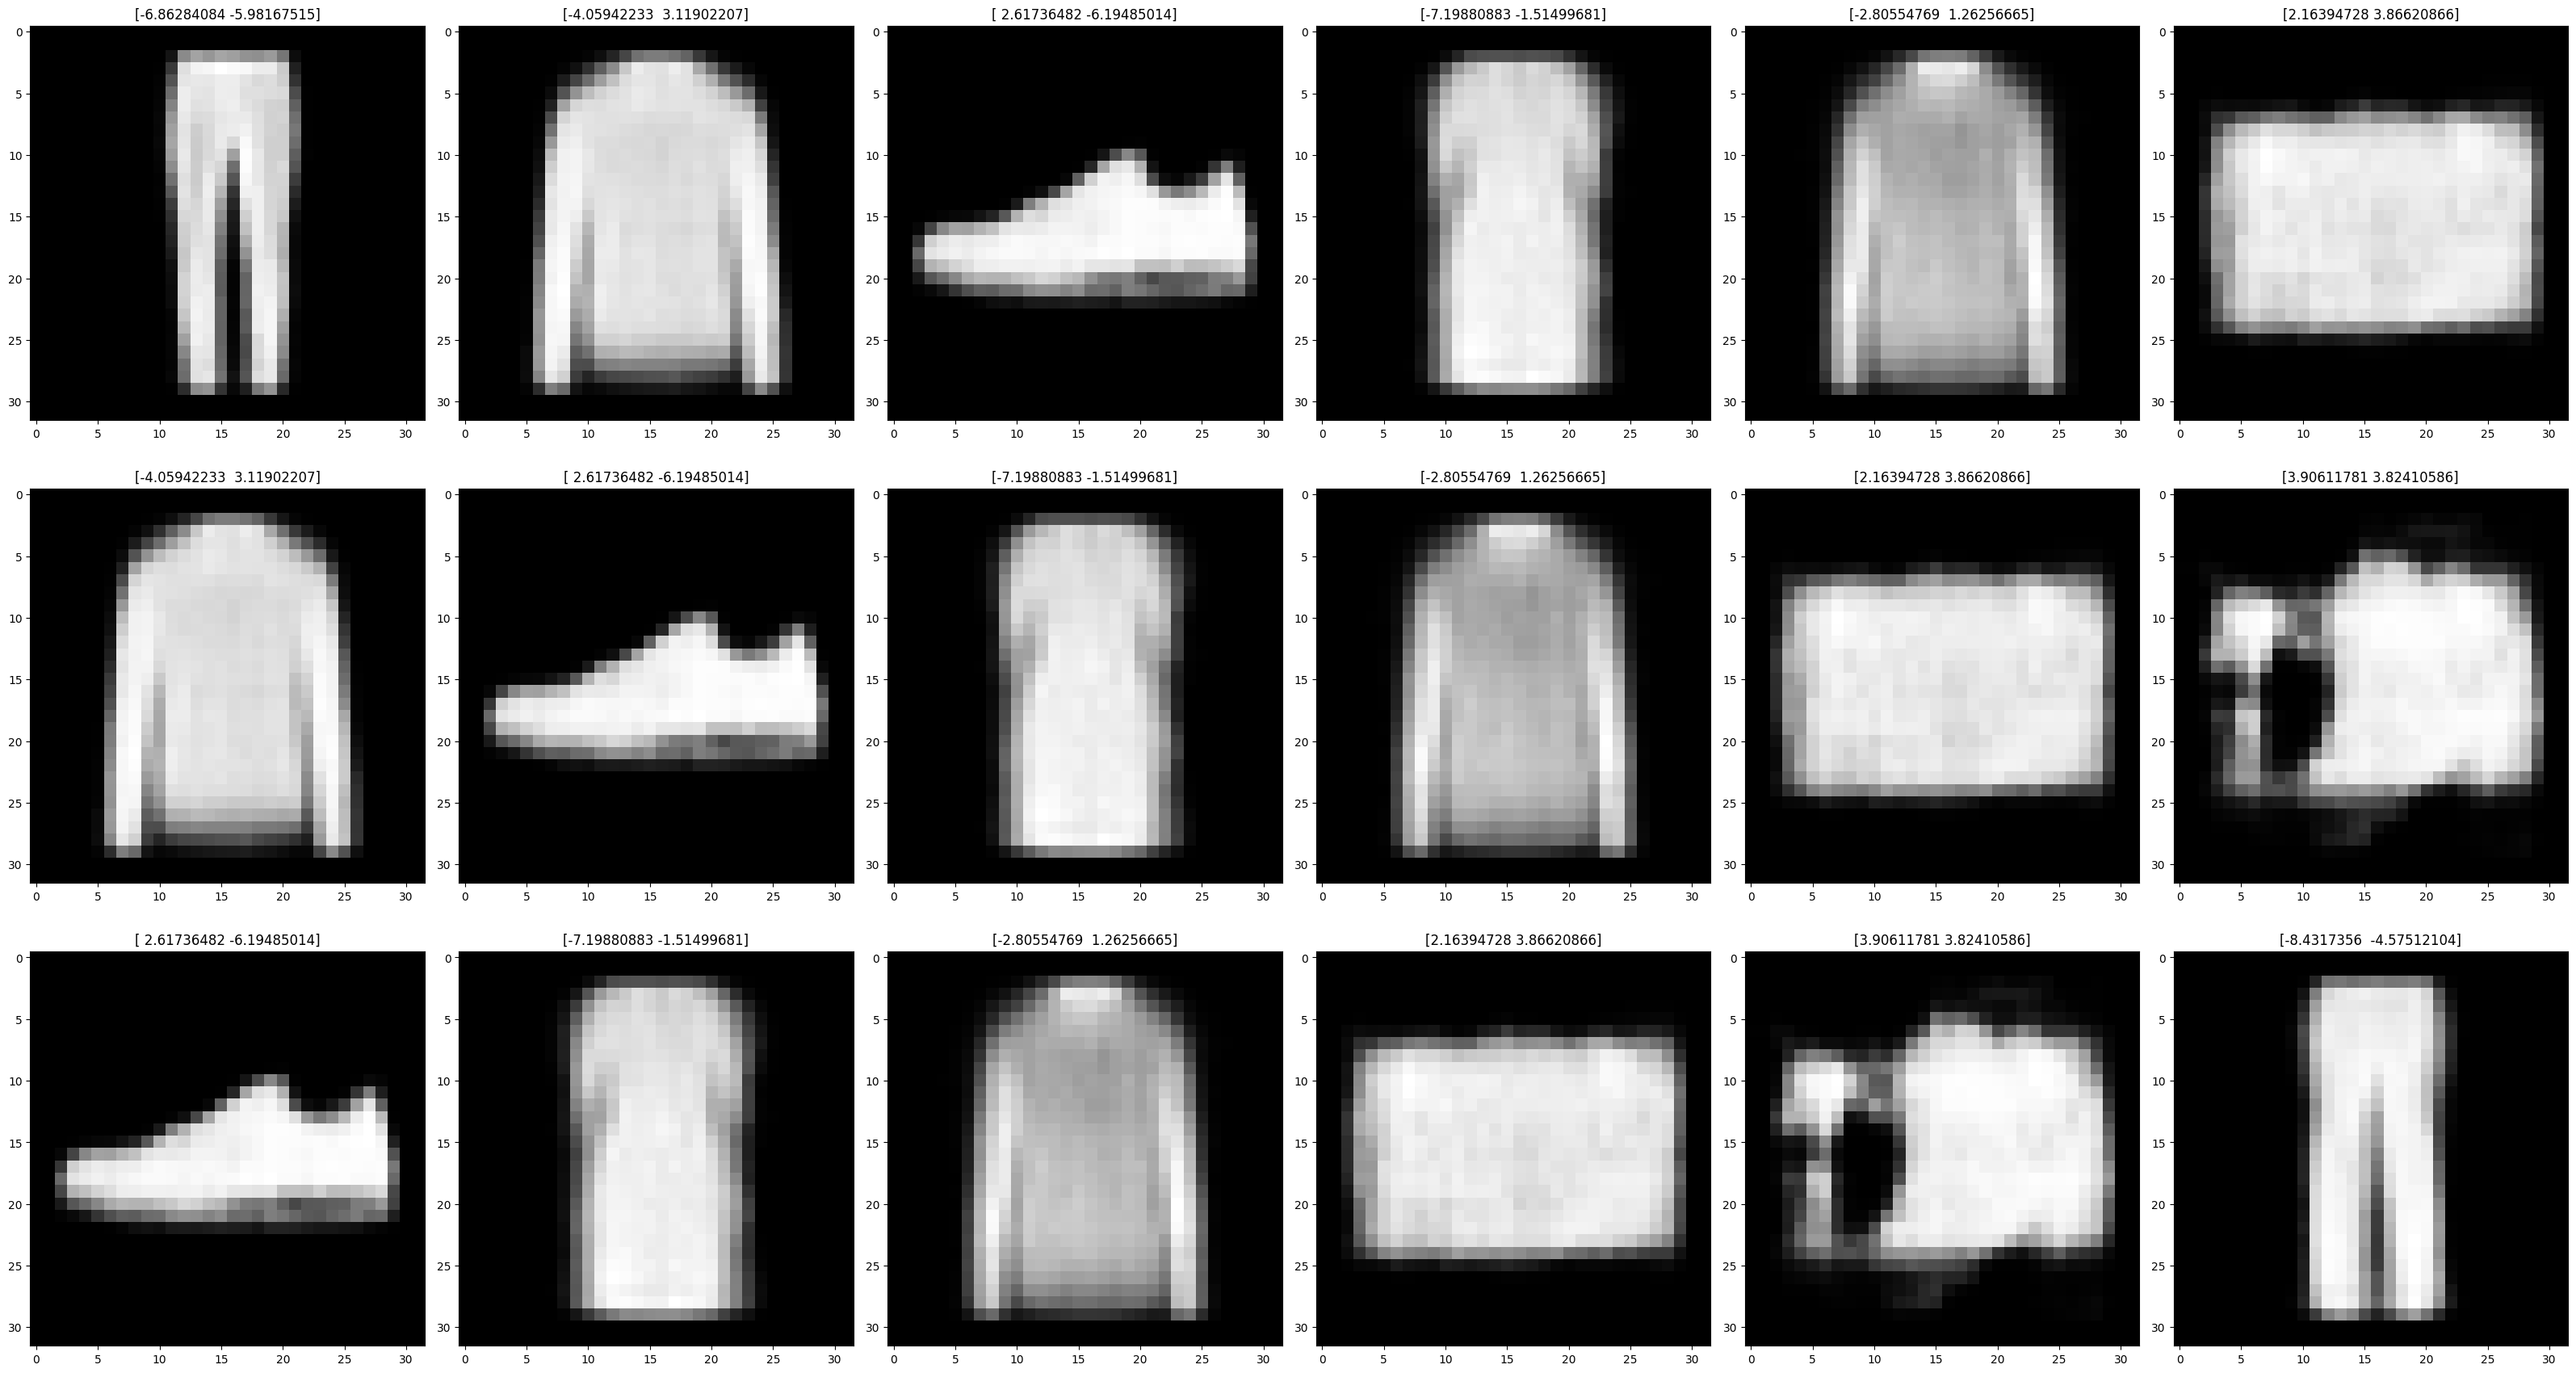

In [14]:
plt.figure()

f, ax = plt.subplots(3, 6, figsize=(32,32))
for y in range(3):
  for x in range(6):
    ax[y, x].imshow(reconstructions[y+x], cmap="gray")
    ax[y, x].set_title(f"{sample[y+x]}")
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()


In [17]:
import tensorflow as tf

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
encoder_input = layers.Input(shape=(32,32,1), name='encoder_input')
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

In [19]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras import metrics, losses

class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name='total_loss')
    self.reconstruction_loss_tracker = metrics.Mean(name='recognition_loss')
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(
          500 * losses.binary_crossentropy(
              data, reconstruction, axis=(1,2,3)
          )
      )

      kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis = 1,
          )
      )

      total_loss = reconstruction_loss + kl_loss

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {m.name: m.result() for m in self.metrics}

In [24]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - kl_loss: 4.4558 - recognition_loss: 147.0829 - total_loss: 151.5388
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - kl_loss: 4.9916 - recognition_loss: 128.6511 - total_loss: 133.6427
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.1353 - recognition_loss: 127.2707 - total_loss: 132.4060
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.2036 - recognition_loss: 126.4561 - total_loss: 131.6597
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.2532 - recognition_loss: 126.2554 - total_loss: 131.5086


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


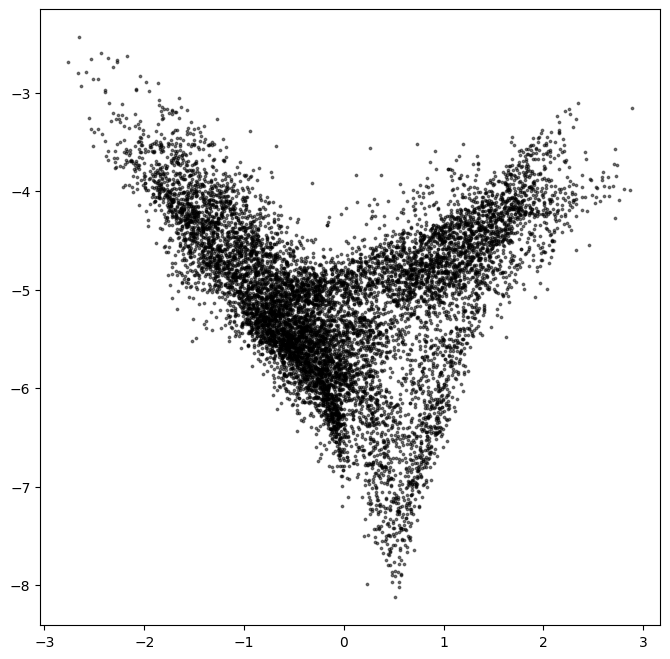

In [26]:
example_images = x_test[:5000]
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[0], embeddings[1], c='black', alpha=0.5, s=3)
plt.show()

In [31]:

sample = np.random.uniform(-3, 3, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 640x480 with 0 Axes>

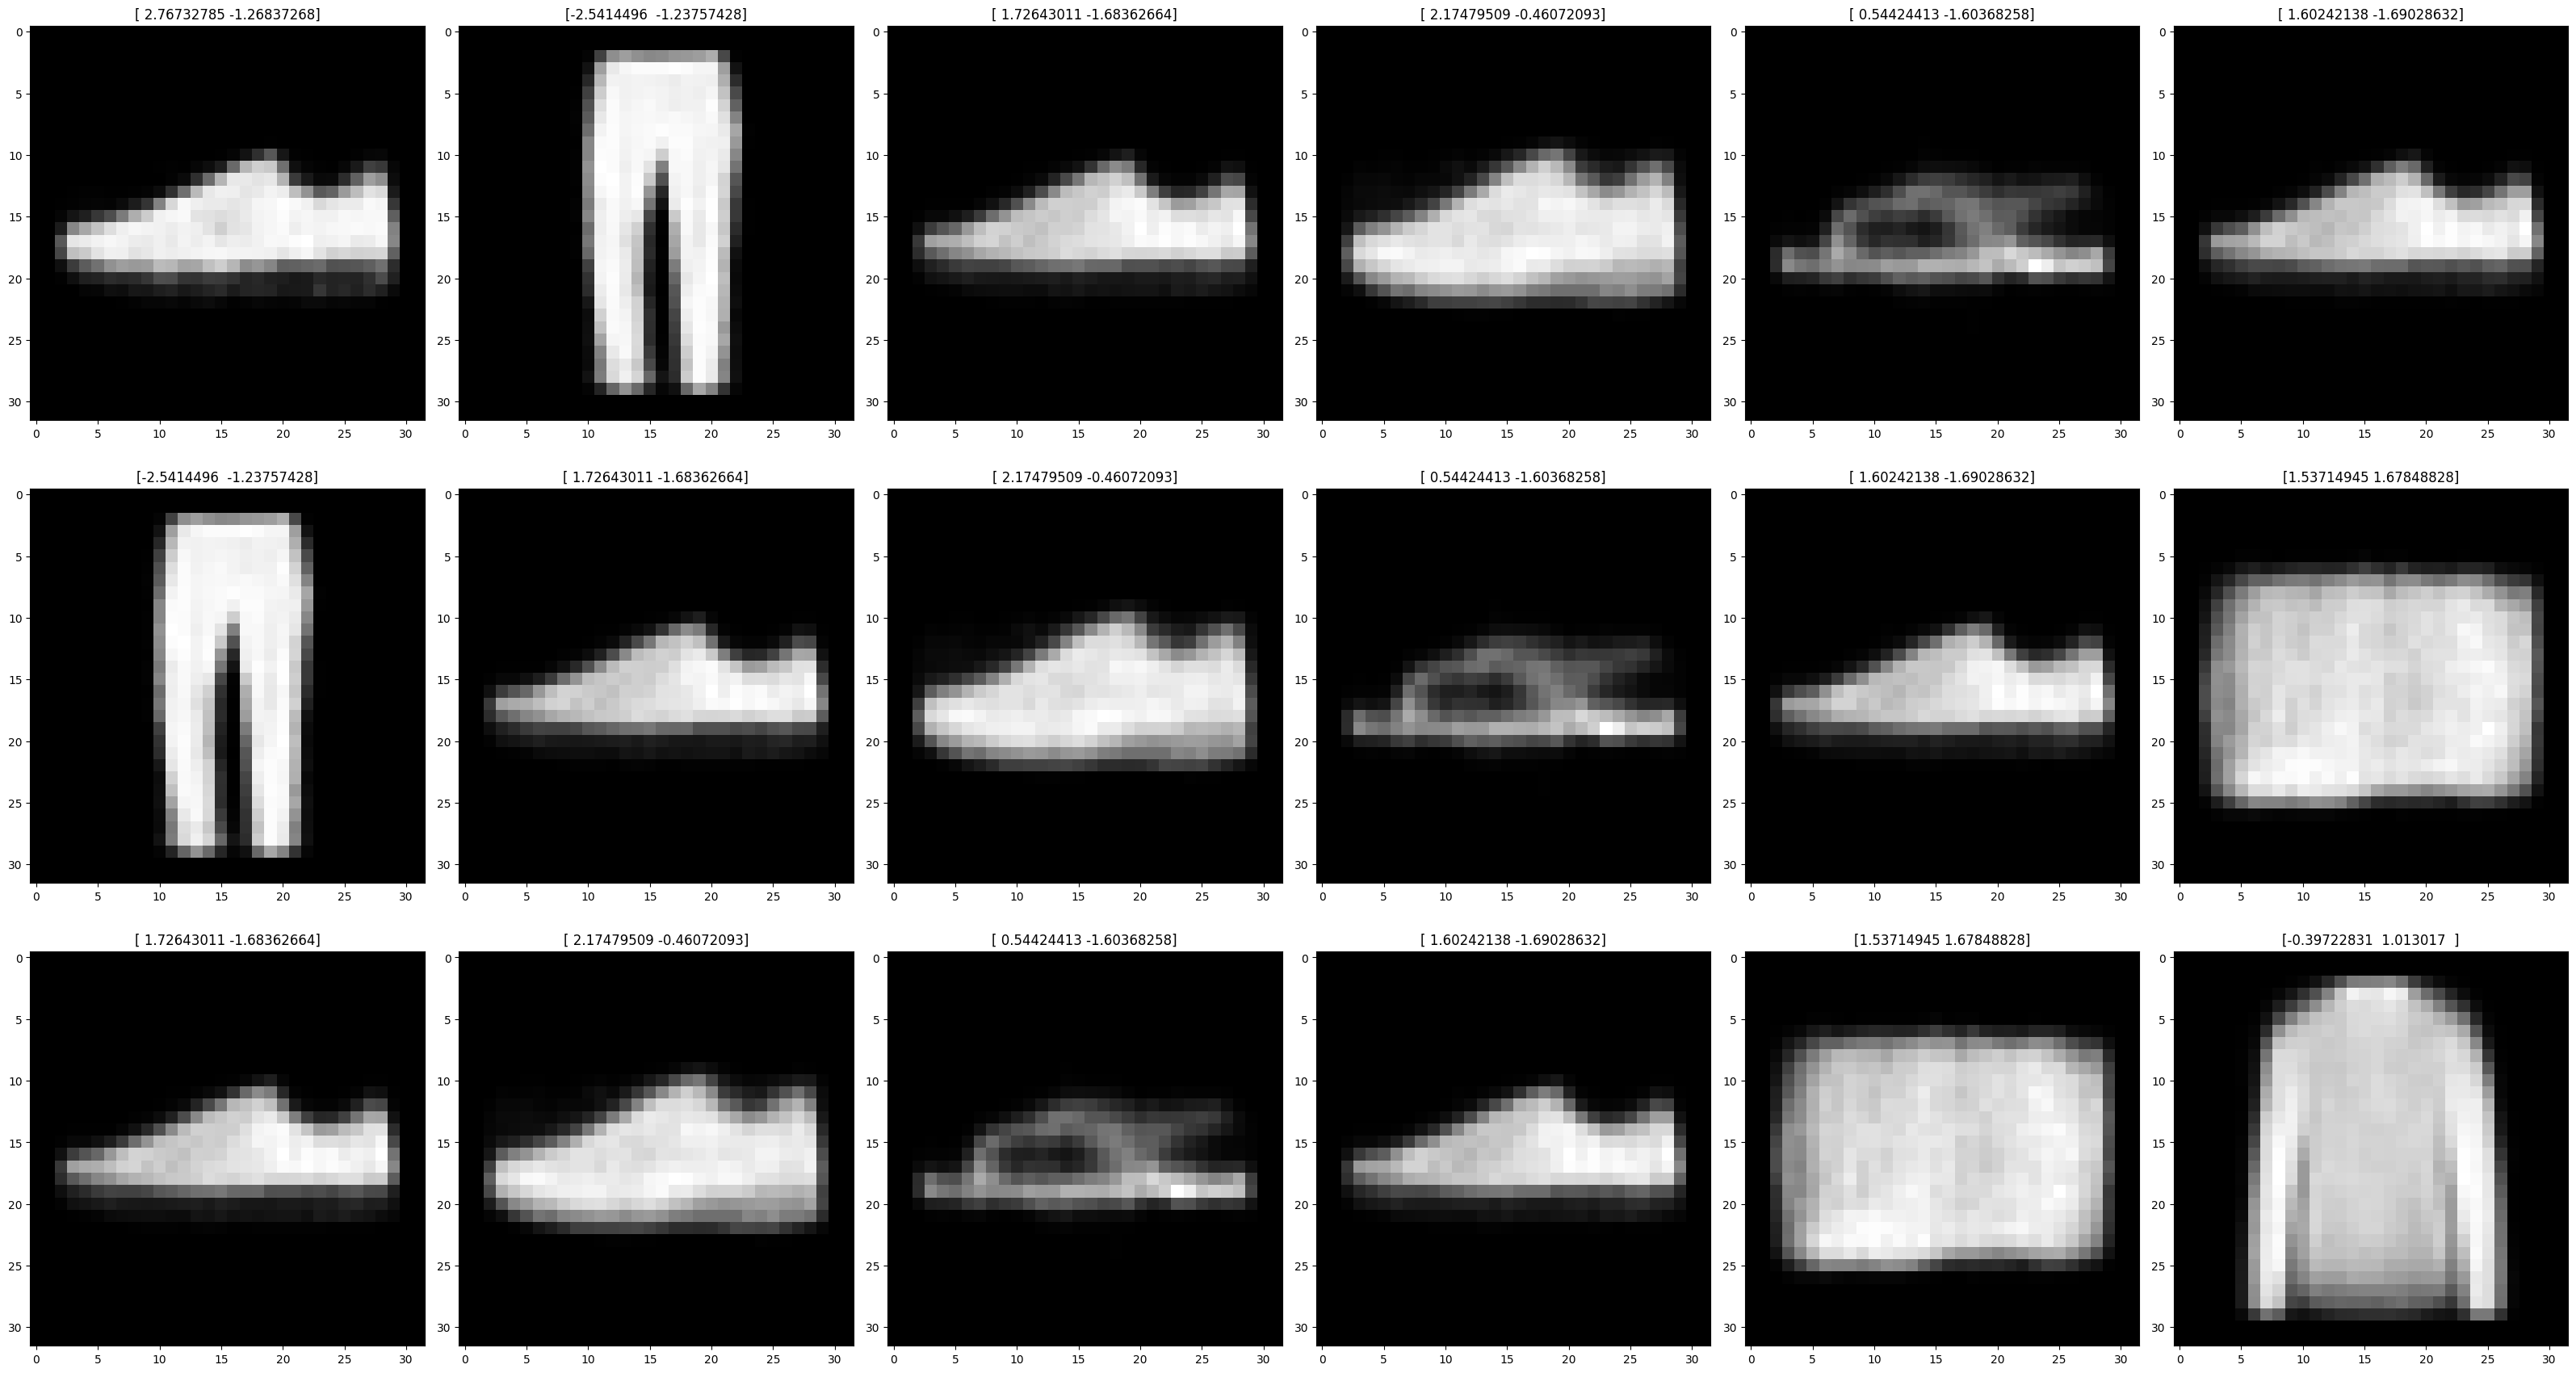

In [32]:
plt.figure()

f, ax = plt.subplots(3, 6, figsize=(32,32))
for y in range(3):
  for x in range(6):
    ax[y, x].imshow(reconstructions[y+x], cmap="gray")
    ax[y, x].set_title(f"{sample[y+x]}")
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()
